<a href="https://colab.research.google.com/github/Narissarach/Project_eye/blob/main/Convolutional_Neural_Networks_(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convolutional Neural Networks (CNN): สร้าง Model เพื่อทำ Image Classification ด้วย TensorFlow

### เตรียมข้อมูล (Data Processing)

ข้อมูล CIFAR-10 จำนวน 60,000 ภาพ โดยแบ่งเป็น 10 หมวด ได้แก่ 
เครื่องบิน แทนด้วย 0,
รถ แทนด้วย 1,
นก แทนด้วย 2,
แมว แทนด้วย 3,
กวาง แทนด้วย 4,
สุนัข แทนด้วย 5,
กบ แทนด้วย 6,
ม้า แทนด้วย 7,
เรือ แทนด้วย 8,
รถบรรทุก แทนด้วย 9


https://medium.com/@app.kkloft/convolutional-neural-networks-cnn-%E0%B8%AA%E0%B8%A3%E0%B9%89%E0%B8%B2%E0%B8%87-model-%E0%B9%80%E0%B8%9E%E0%B8%B7%E0%B9%88%E0%B8%AD%E0%B8%97%E0%B8%B3-image-classification-%E0%B8%94%E0%B9%89%E0%B8%A7%E0%B8%A2-tensorflow-58173661cfeb

#### Import ข้อมูลจาก keras.datasets 

In [1]:
from tensorflow.keras.datasets import cifar10

(in_train, out_train), (in_test, out_test) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


ข้อมูลรูปภาพที่ใช้ train ถูกโหลดเข้าไปเก็บในตัวแปร in_train และ out_train 
และข้อมูลรูปภาพที่ใช้ test ถูกโหลดเข้าไปเก็บในตัวแปร in_test และ out_test

#### ตรวจสอบประเภทข้อมูล และขนาดข้อมูลโดยใช้คำสั่ง type และ shape

In [2]:
type(in_train)
# numpy.ndarray

in_train.shape


(50000, 32, 32, 3)

training dataset มีจำนวน 50,000 ภาพ แต่ละภาพมีขนาด 32x32 และเป็นภาพสีซึ่งประกอบด้วยข้อมูล 3 ชุดได้แก่ R (แดง), G (เขียว), B (น้ำเงิน)

#### ดูภาพที่โหลดเข้ามา ใช้คำสั่ง imshow จาก matplotlib.pyplot
คำสั่ง imshow (in_train[0]) จะแสดงภาพแรกในชุดข้อมูล input ที่ load ไว้ในตัวแปร in_train 

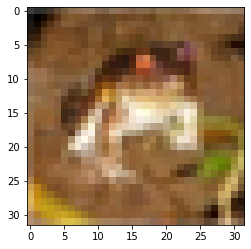

In [3]:
import matplotlib.pyplot as plt
plt.imshow(in_train[0])

#### Preprocess Output
แปลงค่าของชุดข้อมูลภาพให้อยู่ในช่วง 0 ถึง 1 โดยการตรวจสอบค่าสูงสุดของชุดข้อมูลแล้วนำไปหารแต่ละค่า

In [4]:
in_train.max() #ค่าสูงสุดคือ 255

255

In [5]:
in_train = in_train/255 #นำค่าสูงสุดไปหาร
in_test = in_test/255

#### ตรวจสอบข้อมูล output ในชุดข้อมูล training 

In [6]:
type(out_train)

numpy.ndarray

In [7]:
out_train.shape

(50000, 1)

In [8]:
out_train[0]

array([6], dtype=uint8)

ข้อมูล output มีจำนวน 50,000 โดยเป็นข้อมูล 1 มิติ จากตัวอย่างแสดงให้เห็นว่า output แรกของชุดข้อมูล train มีค่าเป็น 6 ซึ่งเป็นค่าแทนหมวดภาพ กบ

#### แปลงรูปแบบข้อมูลให้เป็น one-hot categorical โดยใช้ to_categorical จาก tensorflow.keras.utils
รูปแบบ one-hot categorical ซึ่งหมายถึง array ที่มีค่าเป็น 0 ทั้งหมด ยกเว้นตำแหน่งที่ตรงกับตัวเลขเดิมจะมีค่าเป็น 1

In [9]:
from tensorflow.keras.utils import to_categorical
out_cat_train = to_categorical(out_train, 10)
out_cat_test = to_categorical(out_test, 10)

In [10]:
out_train[0] #ตำแหน่งที่ 6

array([6], dtype=uint8)

In [11]:
out_cat_train[0] #ตำแหน่งเดิมถูกแทนที่ด้วย 1

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

### สร้างโมเดล (Model Creation)

#### ทำการ import library ที่จำเป็น
เริ่มจาก model ที่เป็นแบบ Sequential และ layer ต่างๆ ได้แก่ Conv2D, MaxPool2D, Dense และ Flatten

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

Conv2D layer — จะสร้าง feature map หรือ kernel ที่นำไป apply กับภาพที่เป็น input โดยจะ scan ไปให้ทั่วภาพ

Pooling layer — ช่วนลดขนาดของ output ที่ได้จาก layer ก่อนหน้าลง โดยคงไว้ซึ่งคุณสมบัติของข้อมูลให้มากที่สุด

Flatten layer — ทำการแปลงข้อมูล output ที่มีหลายมิติ ให้เป็น 1 มิติ เพื่อเตรียมข้อมูลให้อยู่ใน format สำหรับเป็น input ให้กับ Fully connected Layer

Dense layer or Fully connected Layer— ข้อมูลจากทุกๆ input จะเชื่อมต่อไปยัง output ทุกๆ node โดยแต่ละการเชื่อมต่อจะคูณด้วย weight ที่ต่างกัน และที่ทุกๆ node ของ output จะสามารถกำหนด activation ที่เหมาะสมได้

#### สร้าง model ของ Convolutional Neural Networks โดยใช้ Keras

In [13]:
# Create Sequential Model
model = Sequential()
# Layer 1: Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=(4,4), input_shape=(32,32,3), activation='relu',))
# Layer 2: Pooling Layer
model.add(MaxPool2D(pool_size=(2,2)))
# Layer 3: Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=(4,4), input_shape=(32,32,3), activation='relu',))
# Layer 4: Pooling Layer
model.add(MaxPool2D(pool_size=(2,2)))
# Layer 5: Flatten Layer
model.add(Flatten())
# Layer 6: Dense Layer (Hidden Layer)
model.add(Dense(256, activation='relu'))
# Layer 7: Dense Layer (Output Layer)
model.add(Dense(10, activation='softmax'))

Convolutional Layer รองรับ Input เป็นภาพสีขนาด 32x32 ให้ Output ออกมา 32 features โดยมี kernel ขนาด 4x4 และใช้ Activation Function เป็น Rectified Linear Unit

Pooling Layer ใช้เป็น Max Pool ขนาด 2x2 โดยจะทำการลดขนาด input ลงได้ถึง 1/4

Flatten layer ที่ทำการแปลงข้อมูล multi dimension ให้เป็น vector

Dense Layer แรกเป็น Hidden Layer กำหนดให้มีจำนวน output เป็น 256 และใช้ Activation Function เป็น Rectified Linear Unit

Dense Layer ที่สองเป็น Output Layer ของ Network เราต้องกำหนดให้มีจำนวน output เท่ากับจำนวนหมวดหมู่ภาพที่เราต้องการจัดแบ่ง ในตัวอย่างคือกำหนดเป็น 10 และเราใช้ Activation Function เป็น Softmax เนื่องจาก Output ของเราเป็น Multi-Class

#### ใช้คำสั่ง summary เพื่อเรียกดูรูปแบบ model และจำนวนตัวแปรในแต่ละ layer

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 29, 29, 32)        1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        16416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 256)               2

#### config ค่าให้กับ model โดยใช้คำสั่ง compile
กำหนดให้ model ใช้ Function loss ชื่อ categorical_crossentropy โดย model จะปรับค่าในขั้นตอนการ training เพื่อลดค่าของ loss

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### ให้ model เริ่ม train ด้วยคำสั่ง fit

In [16]:
model.fit(in_train, out_cat_train, epochs=15, validation_data=(in_test, out_cat_test))

Epoch 1/15
1563/1563 [==============================] - 73s 46ms/step - loss: 1.5178 - accuracy: 0.4495 - val_loss: 1.3013 - val_accuracy: 0.5338
Epoch 2/15
1563/1563 [==============================] - 63s 40ms/step - loss: 1.1870 - accuracy: 0.5796 - val_loss: 1.1301 - val_accuracy: 0.6002
Epoch 3/15
1563/1563 [==============================] - 62s 40ms/step - loss: 1.0338 - accuracy: 0.6391 - val_loss: 1.0729 - val_accuracy: 0.6290
Epoch 4/15
1563/1563 [==============================] - 62s 40ms/step - loss: 0.9205 - accuracy: 0.6793 - val_loss: 1.0068 - val_accuracy: 0.6490
Epoch 5/15
1563/1563 [==============================] - 62s 40ms/step - loss: 0.8231 - accuracy: 0.7123 - val_loss: 0.9635 - val_accuracy: 0.6660
Epoch 6/15
1563/1563 [==============================] - 62s 40ms/step - loss: 0.7449 - accuracy: 0.7393 - val_loss: 0.9643 - val_accuracy: 0.6750
Epoch 7/15
1563/1563 [==============================] - 62s 40ms/step - loss: 0.6750 - accuracy: 0.7634 - val_loss: 0.9557 -

แบ่งข้อมูลในการ training เป็น 15 รอบ (epochs) ในแต่ละรอบจะใช้ข้อมูลทั้งหมดจากตัวแปร in_train และ out_cat_train สำหรับการ validate จะใช้ข้อมูล test

In [24]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2)
model.fit(in_train, out_cat_train, epochs=15, validation_data=(in_test, out_cat_test), callbacks=[early_stop])

Epoch 1/15
1563/1563 [==============================] - 64s 41ms/step - loss: 0.1693 - accuracy: 0.9399 - val_loss: 1.9545 - val_accuracy: 0.6681
Epoch 2/15
1563/1563 [==============================] - 62s 40ms/step - loss: 0.1573 - accuracy: 0.9437 - val_loss: 2.0711 - val_accuracy: 0.6553
Epoch 3/15
1563/1563 [==============================] - 62s 39ms/step - loss: 0.1472 - accuracy: 0.9480 - val_loss: 2.2341 - val_accuracy: 0.6605


ตัวอย่างข้างบน เรากำหนดให้ model คอย monitor ค่า loss จาก validation data แล้วถ้าค่า loss ใน รอบการ training ไม่ลดลงหรือมีค่าเพิ่มขึ้น ให้หยุดการ training ค่า patience=2 หมายถึงให้หยุดเมื่อค่า loss เพิ่มขึ้น 2 รอบ (epochs) แล้ว ###ในตย.มี 8 รอบ

### การประเมินผลโมเดล (Model Evaluation)

#### ดูผลการรันย้อนหลังด้วยคำสั่ง history โดยคำสั่งนี้จะแสดงตัววัด หรือ metrics ในทุกรอบการรัน

In [21]:
import pandas as pd

In [25]:
metrics = pd.DataFrame(model.history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,0.169257,0.93988,1.954508,0.6681
1,0.157287,0.94366,2.071125,0.6553
2,0.147216,0.94798,2.234104,0.6605


#### การ plot graph ของ metrics

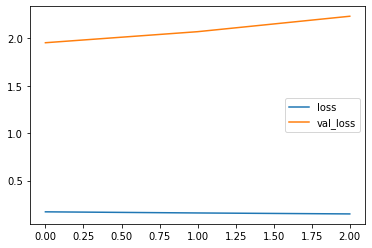

In [26]:
metrics[['loss', 'val_loss']].plot()

กราฟระหว่างค่า loss ที่ได้จากชุดข้อมูล train กับ ชุดข้อมูล test แสดงให้เห็นว่าในรอบการรันที่ 6 และ 7 ค่า loss ของชุดข้อมูล train ยังคงลดลง แต่ค่า loss ของชุดข้อมูล test เริ่มเพิ่มขึ้น หากเรายัง train model ต่อไปก็อาจทำให้ model ของเราเกิด overfit ขึ้นได้

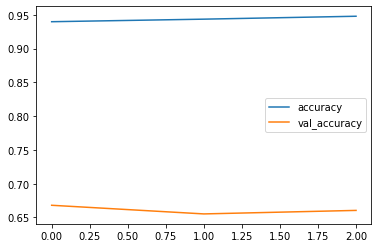

In [27]:
metrics[['accuracy', 'val_accuracy']].plot()

สำหรับค่าความถูกต้องหรือ accuracy นั้นก็แสดงไปในทิศทางที่สอดคล้องกัน คือในรอบการ train ที่ 6 และ 7 แม้ว่าค่าความถูกต้องของชุดข้อมูล train จะเพิ่มขึ้น แต่เมื่อทดสอบกับชุดข้อมูล test พบว่าค่าเริ่มลดลง การหยุด train model จึงช่วยให้ model ไม่เกิด overfit เกินไป

#### คำสั่งที่ใช้หาค่าตัววัด model คือ evaluate

In [28]:
model.evaluate(in_test, out_cat_test, verbose=0)

[2.2341036796569824, 0.6604999899864197]

Output # [0.9964422744750977, 0.6838]
สำหรับ model ของเรามีตัววัด 2 ตัว ค่าแรกคือ loss และค่าที่สองคือ accuracy

### การนำโมเดลไปใช้งาน

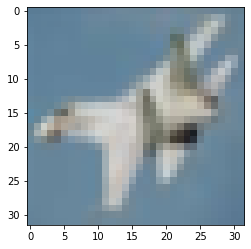

In [31]:
from tensorflow.keras.datasets import cifar10
(in_train, out_train), (in_test, out_test) = cifar10.load_data()
my_image = in_test[10]
plt.imshow(my_image)


#### คำสั่งที่ใช้ทำนายผลคือ predict_classes

In [32]:
model.predict_classes(my_image.reshape(1,32,32,3))

AttributeError: ignored

Output # array([0]) model ทำนายว่าเป็นภาพให้หมวด 0 หรือ เครื่องบิน